In [1]:
import pandas as pd
from glob import glob
import numpy as np

## HTS Analysis

In [3]:
filepaths = glob("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\*.csv")

In [4]:
LOD_percentages = []
above_LOD_count = []
combined_dict = {}
for filepath in filepaths:
    dataframe_csv = pd.read_csv(filepath, encoding = "ISO-8859-1", usecols=lambda x: x not in ["Time", "T° 340"])
    column_name = filepath[-8:-4]
    slopes = dataframe_csv.apply(lambda x: np.polyfit(dataframe_csv.index, x, 1)[0])
    reshaped_df = pd.DataFrame(slopes.values.reshape(16,24), index=list('ABCDEFGHIJKLMNOP'), columns=list(range(1,25)))
    neg_mean = (reshaped_df[1].mean() + reshaped_df[2].mean())/2
    neg_std = pd.concat([reshaped_df[1],reshaped_df[2]]).std()
    LOD = (-1)*abs(neg_mean + 3*neg_std)
    pos_mean = (reshaped_df[23].mean() + reshaped_df[24].mean())/2
    LOD_percentage = (LOD*100)/pos_mean
    percentage_activity = slopes.apply(lambda x : (((x - neg_mean)*100)/pos_mean))
    LOD_percentages.append(LOD_percentage)
    above_LOD_count.append(percentage_activity.where(percentage_activity > LOD_percentage, np.nan).count())
    combined_dict[column_name] = percentage_activity.to_list()
combined_df = pd.DataFrame(data=combined_dict, index=slopes.index)
combined_df_display = pd.DataFrame(combined_df)
combined_df_display.loc["LOD percentage"] = LOD_percentages
combined_df_display.loc["Above LOD Count"] = above_LOD_count
combined_df_display

,1-R1,1-R2,2-R1,2-R2,3-R1,3-R2,4-R1,4-R2,5-R1,5-R2,6-R1,6-R2
A1,-0.454741,0.672701,0.528338,0.916917,0.090003,-0.469922,11.035921,-0.863511,0.394905,1.924535,-0.166397,0.163383
A2,0.192002,0.672701,0.835735,-0.120880,4.006912,0.610120,-0.606369,1.576953,-0.683859,0.046463,0.381735,-0.391128
A3,-1.020640,0.771902,0.118476,0.633882,-0.601217,0.610120,-0.683985,0.474808,-0.298587,0.515981,-0.009788,-0.549559
A4,-0.616426,0.573501,0.425873,-0.875641,-1.868452,-0.137602,-0.994446,-0.706062,-0.144477,0.046463,-0.009788,0.480246
A5,-0.131370,0.573501,1.040666,0.162156,3.315693,2.687125,-0.528754,0.553533,-0.529750,-0.110043,5.236627,-0.866422
...,...,...,...,...,...,...,...,...,...,...,...,...
P22,-0.858955,0.375101,0.835735,0.445191,-1.407639,0.111639,-0.916830,-0.391163,0.394905,0.281222,0.146821,0.084167
P23,103.913296,101.559303,101.149536,100.734123,98.358354,100.472519,102.699556,103.761563,99.487105,104.279461,103.430725,103.777602
P24,104.640881,102.948106,105.760487,101.960611,102.736077,104.294208,100.759174,108.721216,103.570999,107.018316,106.014780,106.787801
LOD percentage,0.802278,1.963182,2.376378,1.899767,5.746865,0.425204,2.401031,0.771107,0.935854,0.885130,1.592567,0.804021


In [5]:
LOD_avg_cutoff = np.mean(LOD_percentages)
LOD_avg_cutoff

1.716948778506576

In [6]:
LOD_percentages

[0.8022782448852165,
 1.9631820982061519,
 2.3763783935249236,
 1.8997665139734345,
 5.746864931541303,
 0.425204050601918,
 2.401031132613852,
 0.7711074764966598,
 0.9358540780383339,
 0.8851304543629532,
 1.5925673455582974,
 0.8040206222758678]

In [7]:
remove_list = [str(x) + '1' for x in list('ABCDEFGHIJKLMNOP')]+[str(x) + '2' for x in list('ABCDEFGHIJKLMNOP')]+[str(x) + '23' for x in list('ABCDEFGHIJKLMNOP')]+[str(x) + '24' for x in list('ABCDEFGHIJKLMNOP')]
frames = []
for i in range(1,7):
    i = str(i)
    tmp_df = pd.DataFrame(combined_df[[i+'-R1',i+'-R2']]).rename(columns={i+'-R1':'R1', i+'-R2':'R2'})
    tmp_df = tmp_df.drop(remove_list)
    index_list = ['Plate '+i+'-' + x for x in tmp_df.index]
    tmp_df.index = index_list
    tmp_df['Is_Considered'] = (tmp_df['R1'] > 1.59) & (tmp_df['R2'] > 0.8)
    frames.append(tmp_df)
final_df = pd.concat(frames)
final_df['Rate Average'] = final_df[['R1','R2']].mean(axis=1)
final_df[final_df['Is_Considered']]

,R1,R2,Is_Considered,Rate Average
Plate 1-D4,9.084708,10.394321,True,9.739514
Plate 1-D10,4.072455,4.045508,True,4.058982
Plate 1-D12,46.676604,150.861802,True,98.769203
Plate 1-E4,2.051386,1.069502,True,1.560444
Plate 1-E16,2.293914,3.648707,True,2.971311
...,...,...,...,...
Plate 6-N18,1.791220,1.510051,True,1.650635
Plate 6-O13,4.531885,6.817507,True,5.674696
Plate 6-P4,3.357314,3.015150,True,3.186232
Plate 6-P15,1.634611,1.113972,True,1.374291


In [8]:
final_df.sort_values('Rate Average', ascending=False)

,R1,R2,Is_Considered,Rate Average
Plate 1-D12,46.676604,150.861802,True,98.769203
Plate 6-B3,135.300739,57.277948,True,96.289344
Plate 2-L17,39.772654,123.660004,True,81.716329
Plate 2-B10,83.115594,76.298720,True,79.707157
Plate 3-C7,64.258199,66.575798,True,65.416998
...,...,...,...,...
Plate 4-J10,-1.537753,-3.855048,False,-2.696400
Plate 4-D20,-4.176672,-1.257134,False,-2.716903
Plate 6-G5,-3.533500,-3.322111,False,-3.427805
Plate 2-H10,-7.054115,-1.158677,False,-4.106396


In [9]:
compound_df = pd.read_excel('C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\All 1A Data_EPA ECHO plate location.xlsx', usecols=['Dest plate', 'Dest well', 'EPA_SAMPLE_ID','PREFERRED_NAME'])
def combine_columns(row):
    if row['Dest well'][1] == '0':
        dest_well = row['Dest well'][0]+row['Dest well'][2]
    else:
        dest_well = row['Dest well']
    return "Plate " + str(row['Dest plate']) + "-" + dest_well

compound_df['ID'] = compound_df.apply(combine_columns, axis=1)
compound_df = compound_df.drop(columns=['Dest plate', 'Dest well'])
compound_df = compound_df.set_index("ID")
compound_df

,EPA_SAMPLE_ID,PREFERRED_NAME
ID,,
Plate 1-A3,EPAPLT0439A09,Imazamox
Plate 1-B3,EPAPLT0439A10,Dimethyl succinate
Plate 1-C3,EPAPLT0439B09,"Toluene 2,4-diisocyanate"
Plate 1-D3,EPAPLT0439B10,1-Methylnaphthalene
Plate 1-E3,EPAPLT0439C09,MEHP
...,...,...
Plate 6-L22,EPAPLT0536G01,1-(Methylamino)-4-(2-hydroxyethylamino)anthraq...
Plate 6-M22,EPAPLT0536G04,Sodium thiomethoxide
Plate 6-N22,EPAPLT0536G05,Tris(tribromoneopentyl)phosphate


In [10]:
final_df = compound_df.join(final_df).sort_values('Rate Average', ascending=False)

<Axes: xlabel='R1', ylabel='R2'>

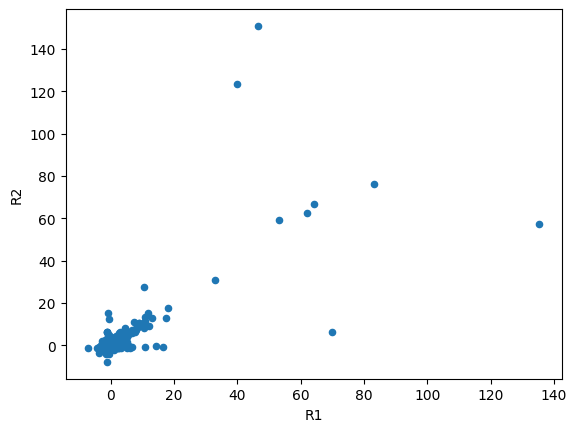

In [11]:
final_df.plot.scatter(x='R1',y='R2')

In [12]:
final_df

,EPA_SAMPLE_ID,PREFERRED_NAME,R1,R2,Is_Considered,Rate Average
ID,,,,,,
Plate 1-D12,EPAPLT0443B12,Dichlone,46.676604,150.861802,True,98.769203
Plate 6-B3,EPAPLT0481G11,9-Phenanthrol,135.300739,57.277948,True,96.289344
Plate 2-L17,EPAPLT0454H03,Methylene blue,39.772654,123.660004,True,81.716329
Plate 2-B10,EPAPLT0449G03,Diquat dibromide monohydrate,83.115594,76.298720,True,79.707157
Plate 3-C7,EPAPLT0458H12,"2,5-Di-tert-butylbenzene-1,4-diol",64.258199,66.575798,True,65.416998
...,...,...,...,...,...,...
Plate 4-J10,EPAPLT0466C03,Dioctyl sebacate,-1.537753,-3.855048,False,-2.696400
Plate 4-D20,EPAPLT0470B08,"Disodium 4,4'-bis(2-sulfostyryl)biphenyl",-4.176672,-1.257134,False,-2.716903
Plate 6-G5,EPAPLT0483C03,FR150011,-3.533500,-3.322111,False,-3.427805


In [13]:
final_LOD_cutoff_df = final_df[final_df["Is_Considered"]]
final_LOD_cutoff_df

,EPA_SAMPLE_ID,PREFERRED_NAME,R1,R2,Is_Considered,Rate Average
ID,,,,,,
Plate 1-D12,EPAPLT0443B12,Dichlone,46.676604,150.861802,True,98.769203
Plate 6-B3,EPAPLT0481G11,9-Phenanthrol,135.300739,57.277948,True,96.289344
Plate 2-L17,EPAPLT0454H03,Methylene blue,39.772654,123.660004,True,81.716329
Plate 2-B10,EPAPLT0449G03,Diquat dibromide monohydrate,83.115594,76.298720,True,79.707157
Plate 3-C7,EPAPLT0458H12,"2,5-Di-tert-butylbenzene-1,4-diol",64.258199,66.575798,True,65.416998
...,...,...,...,...,...,...
Plate 5-B13,EPAPLT0475E10,1-Dodecyl-2-pyrrolidinone,1.704833,1.298511,True,1.501672
Plate 2-L3,EPAPLT0447E08,Tri-allate,1.757925,1.199953,True,1.478939
Plate 3-A19,EPAPLT0463B08,Bromoxynil,1.818051,0.942441,True,1.380246


In [14]:
hits_dict = {}
Rate_avg = final_LOD_cutoff_df["Rate Average"]
for i in list(range(100,9,-10))+[5,3,2,1,0]:
    #print(r"Hits >= " + str(i) + r"% of Positive control : ",Rate_avg.where(Rate_avg >= i).count())
    hits_dict[str(i)+r"% and above"] = [Rate_avg.where(Rate_avg >= i).count(), Rate_avg.where(Rate_avg >= i).count()*100/final_df["Rate Average"].count()]
hits_df = pd.DataFrame.from_dict(hits_dict, orient="index", columns=["Number of Hits", "Toxcast Phase II library %"])
hits_df.index.name = "Activity compared to PR"
hits_df

,Number of Hits,Toxcast Phase II library %
Activity compared to PR,,
100% and above,0,0.000000
90% and above,2,0.104167
80% and above,3,0.156250
70% and above,4,0.208333
60% and above,6,0.312500
50% and above,7,0.364583
40% and above,7,0.364583
30% and above,9,0.468750
20% and above,9,0.468750


In [15]:
final_LOD_cutoff_df.to_excel("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\2Y3_HTS_analysis_above_LOD.xlsx")

In [16]:
final_df.count()

EPA_SAMPLE_ID     1920
PREFERRED_NAME    1920
R1                1920
R2                1920
Is_Considered     1920
Rate Average      1920
dtype: int64

In [17]:
final_LOD_cutoff_df.count()

EPA_SAMPLE_ID     110
PREFERRED_NAME    110
R1                110
R2                110
Is_Considered     110
Rate Average      110
dtype: int64

In [18]:
toxcast_library = pd.read_excel("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\toxcast_library.xlsx")
toxcast_library = toxcast_library[["PREFERRED NAME","SMILES"]]
toxcast_library.rename(columns={"PREFERRED NAME":"PREFERRED_NAME"}, inplace=True)

In [19]:
toxcast_library

,PREFERRED_NAME,SMILES
0,Fluthiacet-methyl,COC(=O)CSC1=C(Cl)C=C(F)C(=C1)N=C1SC(=O)N2CCCCN12
1,2-(4-Chloro-2-methylphenoxy)acetic acid,CC1=C(OCC(O)=O)C=CC(Cl)=C1
2,Thiophanate-methyl,COC(=O)NC(=S)NC1=C(NC(=S)NC(=O)OC)C=CC=C1
3,Fludioxonil,FC1(F)OC2=CC=CC(=C2O1)C1=CNC=C1C#N
4,Acephate,COP(=O)(NC(C)=O)SC
...,...,...
6549,Diethyl ethoxymethylenemalonate,CCOC=C(C(=O)OCC)C(=O)OCC
6550,Dapsone,NC1=CC=C(C=C1)S(=O)(=O)C1=CC=C(N)C=C1
6551,1-(4-Chlorophenyl)ethanone,CC(=O)C1=CC=C(Cl)C=C1
6552,Flufenpyr-ethyl,CCOC(=O)COC1=CC(N2N=CC(=C(C)C2=O)C(F)(F)F)=C(F...


In [20]:
final_df_with_mols = final_df.merge(toxcast_library, how='left', on='PREFERRED_NAME').drop_duplicates()
final_df_with_mols = final_df_with_mols.set_index("EPA_SAMPLE_ID")

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import DataStructs
import os
from rdkit import RDConfig
PandasTools.RenderImagesInAllDataFrames(images=True)

In [22]:
final_df_with_mols["SMILES"].fillna("C", inplace=True)
PandasTools.AddMoleculeColumnToFrame(final_df_with_mols, smilesCol='SMILES', molCol='MOL_OBJ', includeFingerprints=True)

,PREFERRED_NAME,R1,R2,Rate Average,MOL_OBJ
EPA_SAMPLE_ID,,,,,
EPAPLT0443B12,Dichlone,46.676604,150.861802,98.769203,
EPAPLT0481G11,9-Phenanthrol,135.300739,57.277948,96.289344,
EPAPLT0454H03,Methylene blue,39.772654,123.660004,81.716329,
EPAPLT0449G03,Diquat dibromide monohydrate,83.115594,76.298720,79.707157,
EPAPLT0458H12,"2,5-Di-tert-butylbenzene-1,4-diol",64.258199,66.575798,65.416998,
...,...,...,...,...,...
EPAPLT0475E10,1-Dodecyl-2-pyrrolidinone,1.704833,1.298511,1.501672,
EPAPLT0447E08,Tri-allate,1.757925,1.199953,1.478939,
EPAPLT0463B08,Bromoxynil,1.818051,0.942441,1.380246,

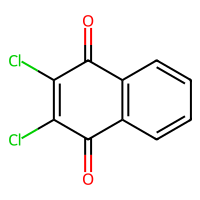
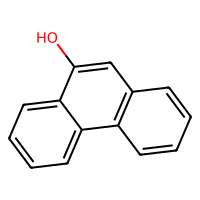
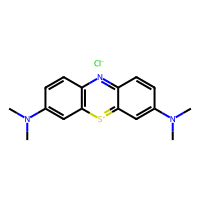
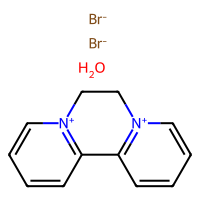
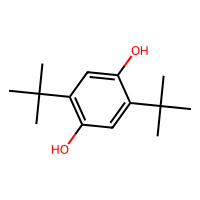
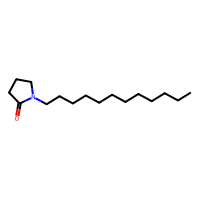
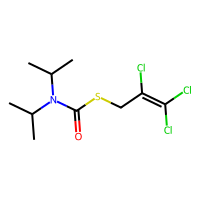
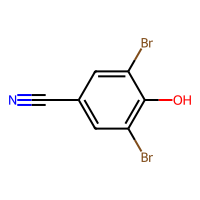
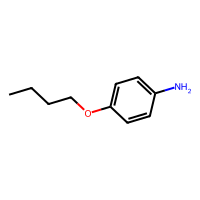
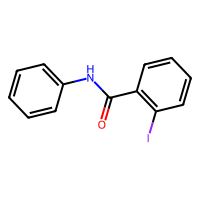

In [23]:
final_df_with_mols_above_lod = final_df_with_mols[final_df_with_mols["Is_Considered"]]
final_df_with_mols_above_lod[["PREFERRED_NAME","R1","R2","Rate Average","MOL_OBJ"]]

In [59]:
final_df_with_mols_above_lod[["PREFERRED_NAME","R1","R2","Rate Average","MOL_OBJ"]].to_html("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\above_LOD_2Y3_screen_data_with_structures.html")

In [60]:
final_df_with_mols[["PREFERRED_NAME","R1","R2","Rate Average","MOL_OBJ"]].to_html("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\2Y3_screen_data_with_structures.html")

In [27]:
PandasTools.SaveXlsxFromFrame(final_df_with_mols_above_lod, "C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\above_LOD_2Y3_screen_data_with_structures.xlsx", molCol='MOL_OBJ')


## HTS Followup

In [29]:
ABS_followup_data = pd.read_excel("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\followup\\2024-02-14_ABS_followup.xlsx")
ROS_followup_data = pd.read_excel("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\followup\\2024-02-14_ROS_followup.xlsx")
follow_up_picklist = pd.read_csv("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\followup\\2024-02-14 Derek_ABS_picklist.csv")

In [30]:
follow_up_slopes = ABS_followup_data.apply(lambda x: np.polyfit(ABS_followup_data.index, x, 1)[0])
follow_up_reshaped_df = pd.DataFrame(follow_up_slopes.values.reshape(16,24), index=list('ABCDEFGHIJKLMNOP'), columns=list(range(1,25)))

neg_mean = follow_up_reshaped_df[23].mean()
neg_std = follow_up_reshaped_df[23].std()
pos_mean = follow_up_reshaped_df[22].mean()
percentage_activity = follow_up_slopes.apply(lambda x : (((x - neg_mean)*100)/pos_mean))
follow_up_reshaped_df_percentage_activity = follow_up_reshaped_df.apply(lambda x : (((x - neg_mean)*100)/pos_mean))
follow_up_comp_list = follow_up_picklist[0:48]
follow_up_comp_list['ID'] = follow_up_comp_list['Source Plate Barcode'].apply(lambda x : "Plate " + x[12])+"-"+follow_up_comp_list['Source Well']
follow_up_comp_list = follow_up_comp_list.merge(compound_df, how='left', on='ID').drop_duplicates()[['EPA_SAMPLE_ID','PREFERRED_NAME']]
follow_up_dict_abs = {"No Protein R1":[1,2,3], "No Protein R2":[4,5,6], "Reductase only R1":[7,8,9], "Reductase only R2":[10,11,12], "2Y3-Reductase R1":[13,14,15], "2Y3-Reductase R2":[16,17,18], "2Y3-Reductase R3":[19,20,21]}
for label in follow_up_dict_abs.keys():
    follow_up_comp_list[label] = follow_up_reshaped_df_percentage_activity[follow_up_dict_abs[label]].to_numpy().flatten('F')


C:\Users\thisi\AppData\Local\Temp\ipykernel_27828\1258482499.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  follow_up_comp_list['ID'] = follow_up_comp_list['Source Plate Barcode'].apply(lambda x : "Plate " + x[12])+"-"+follow_up_comp_list['Source Well']


In [31]:
follow_up_slopes_ros = ROS_followup_data.apply(lambda x: np.polyfit(ROS_followup_data.index, x, 1)[0])
follow_up_reshaped_df_ros = pd.DataFrame(follow_up_slopes_ros.values.reshape(16,24), index=list('ABCDEFGHIJKLMNOP'), columns=list(range(1,25)))

neg_mean_ros = follow_up_reshaped_df_ros[20].mean()
neg_std_ros = follow_up_reshaped_df_ros[20].std()
pos_mean_ros = follow_up_reshaped_df_ros[19].mean()
follow_up_reshaped_df_ros_percentage_activity = follow_up_reshaped_df_ros.apply(lambda x : (((x - neg_mean_ros)*100)/pos_mean_ros))
follow_up_dict_ros = {"Reductase only ROS R1":[1,2,3], "Reductase only ROS R2":[4,5,6], "Reductase only ROS R3":[7,8,9], "2Y3-Reductase ROS R1":[10,11,12], "2Y3-Reductase ROS R2":[13,14,15], "2Y3-Reductase ROS R3":[16,17,18]}
for label in follow_up_dict_ros.keys():
    follow_up_comp_list[label] = follow_up_reshaped_df_ros_percentage_activity[follow_up_dict_ros[label]].to_numpy().flatten('F')

In [32]:
follow_up_comp_list['Avg No Protein'] = follow_up_comp_list[['No Protein R1','No Protein R2']].mean(axis=1)
follow_up_comp_list['Avg Reductase only'] = follow_up_comp_list[['Reductase only R1','Reductase only R2']].mean(axis=1)
follow_up_comp_list['Avg 2Y3-Reductase'] = follow_up_comp_list[['2Y3-Reductase R1','2Y3-Reductase R2','2Y3-Reductase R3']].mean(axis=1)
follow_up_comp_list['Avg Reductase only ROS'] = follow_up_comp_list[['Reductase only ROS R1','Reductase only ROS R2','Reductase only ROS R3']].mean(axis=1)
follow_up_comp_list['Avg 2Y3-Reductase ROS'] = follow_up_comp_list[['2Y3-Reductase ROS R1','2Y3-Reductase ROS R2','2Y3-Reductase ROS R3']].mean(axis=1)
follow_up_comp_list.sort_values("Avg 2Y3-Reductase", ascending=False)

,EPA_SAMPLE_ID,PREFERRED_NAME,No Protein R1,No Protein R2,Reductase only R1,Reductase only R2,2Y3-Reductase R1,2Y3-Reductase R2,2Y3-Reductase R3,Reductase only ROS R1,Reductase only ROS R2,Reductase only ROS R3,2Y3-Reductase ROS R1,2Y3-Reductase ROS R2,2Y3-Reductase ROS R3,Avg No Protein,Avg Reductase only,Avg 2Y3-Reductase,Avg Reductase only ROS,Avg 2Y3-Reductase ROS
9,EPAPLT0454H03,Methylene blue,8.964091,12.019307,97.310773,94.255556,166.307749,153.917148,150.437596,29.817660,33.750273,44.972652,50.271349,10.284370,43.217234,10.491699,95.783164,156.887498,36.180195,34.590984
41,EPAPLT0481G11,9-Phenanthrol,-0.371294,0.053042,97.819976,99.856787,155.529624,157.311834,152.729009,6.764996,8.455525,12.610127,34.752637,35.842089,53.707050,-0.159126,98.838381,155.190155,9.276883,41.433925
10,EPAPLT0449G03,Diquat dibromide monohydrate,-2.917308,-3.341643,41.807670,42.401740,84.495836,86.108312,86.787249,9.514240,7.413886,3.076570,38.970421,37.500173,42.103876,-3.129475,42.104705,85.797132,6.668232,39.524823
36,EPAPLT0481D10,"1,4-Dihydroxy-2-naphthoic acid",-4.020580,-3.765979,37.394579,41.468201,78.470270,75.330186,74.651249,0.334157,6.235639,1.608030,29.179016,26.738849,29.228536,-3.893280,39.431390,76.150568,2.725942,28.382133
11,EPAPLT0450B04,"1,5-Naphthalenediamine",-1.729168,-2.408105,36.121572,35.866971,74.566382,74.905851,73.717711,-0.686991,-0.994360,-0.852628,16.677642,12.321542,14.261381,-2.068636,35.994271,74.396648,-0.844660,14.420188
21,EPAPLT0458H12,"2,5-Di-tert-butylbenzene-1,4-diol",-4.275182,-3.341643,27.974328,29.077600,70.068424,71.171697,69.728956,-4.529101,0.892544,-3.328655,14.073544,12.903835,13.397333,-3.808412,28.525964,70.323026,-2.321738,13.458238
0,EPAPLT0443B12,Dichlone,-1.474566,-1.219965,67.182942,64.127725,55.895613,56.998886,59.035697,10.950335,11.127926,11.862196,22.247848,22.915522,25.082472,-1.347266,65.655333,57.310066,11.313486,23.415281
12,EPAPLT0455G04,Clofentezine,-2.238371,-2.492972,13.377181,13.886384,47.833236,45.881292,52.840397,-3.774340,-1.771320,-3.156187,27.044510,27.107691,24.274775,-2.365671,13.631783,48.851642,-2.900616,26.142325
37,EPAPLT0473E09,1-Naphthol,-2.323238,0.901713,28.228929,21.184957,37.818915,43.674747,39.516257,-5.227512,-2.802713,-7.561807,5.048854,3.771565,4.277016,-0.710762,24.706943,40.336640,-5.197344,4.365812
35,EPAPLT0467F10,Perfluorooctanoic acid,-3.002175,-3.256776,1.071448,-1.219965,14.225853,9.558161,45.881292,-8.787867,-8.977412,-8.678581,125.318868,123.464410,123.237298,-3.129475,-0.074259,23.221768,-8.814620,124.006859


In [109]:
follow_up_comp_list.to_excel("C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\followup\\2024-02-14_ABS_followup_analysis.xlsx")

In [33]:
follow_up_comp_list_with_mols = follow_up_comp_list.merge(toxcast_library, how='left', on='PREFERRED_NAME').drop_duplicates()
follow_up_comp_list_with_mols = follow_up_comp_list_with_mols.set_index("EPA_SAMPLE_ID")

In [37]:
follow_up_comp_list_with_mols["SMILES"].fillna("C", inplace=True)
PandasTools.AddMoleculeColumnToFrame(follow_up_comp_list_with_mols, smilesCol='SMILES', molCol='MOL_OBJ', includeFingerprints=True)

In [39]:
PandasTools.SaveXlsxFromFrame(follow_up_comp_list_with_mols, "C:\\Users\\thisi\\OneDrive\\Desktop\\2Y3_screen_data\\2Y3_followup_raw_analysis.xlsx", molCol='MOL_OBJ')